# Bengali Fake News Classification


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.1 MB/s eta 0:00:00


In [4]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [5]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [6]:
from sklearn.model_selection import train_test_split

auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake-1K.csv")
df = auth[:fake.shape[0]* 15]

df = df.append(fake)


train_df, test_df = train_test_split(df, test_size=0.10, random_state=121, stratify=df['label'])


df = train_df.append(train_df[train_df['label']==0].sample(len(fake)*30, replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)
train_df=df

In [7]:
len(train_df)

57675

In [8]:
train_df[train_df['label']==0].head()

,articleID,domain,date,category,headline,content,label
0,1112,channeldhaka.news,2018-07-25T21:51:22+00:00,Miscellaneous,জসীমের আইফোনে তোলা রোহিঙ্গাদের ছবি প্রথম হলো স...,পড়ন্ত বিকাল। সূয্যিমামার বিদায় বেলায় দূরে পাহা...,0
1,787,motikontho.wordpress.com,2013-03-31T11:39:29+00:00,Miscellaneous,কমিটির সভাপতিকে নিয়ে আল ইহসান সম্পাদকের অসন্ত...,ইসলামী মতিবেদকব্লগ ও ফেসবুকে ইসলাম ও মহানবী হজ...,0
3,114,channeldhaka.news,2019-03-02T01:59:31+00:00,Miscellaneous,মার্চ মাসে জন্ম নেয়‍া ব্যক্তিরা নীতিবান হয় : ব...,ShareTweetআপনাকে প্রপোজ করা ছেলেটির জন্মদিন কি...,0
4,137,bengaliviralnews.com,2018-01-19T10:12:42+00:00,Miscellaneous,IAS পরিক্ষায় মেয়েটিকে প্রশ্ন করা হল- কি এমন জি...,IAS পরীক্ষায় এমন কিছু প্রশ্ন করা হল যা জানলে আ...,0
5,853,earki.com,"১৮:৫৮, জানুয়ারি ১১, ২০১৯",Sports,বিপিএলের গ্যালারিতে যে ১০ উপায়ে দর্শক আনা যেতে...,"বিপিএলের ১০টার মতো ম্যাচ হয়ে গেছে, খেলা জমেও উ...",0


In [9]:
df.head()

,articleID,domain,date,category,headline,content,label
0,1112,channeldhaka.news,2018-07-25T21:51:22+00:00,Miscellaneous,জসীমের আইফোনে তোলা রোহিঙ্গাদের ছবি প্রথম হলো স...,পড়ন্ত বিকাল। সূয্যিমামার বিদায় বেলায় দূরে পাহা...,0
1,787,motikontho.wordpress.com,2013-03-31T11:39:29+00:00,Miscellaneous,কমিটির সভাপতিকে নিয়ে আল ইহসান সম্পাদকের অসন্ত...,ইসলামী মতিবেদকব্লগ ও ফেসবুকে ইসলাম ও মহানবী হজ...,0
2,1493,banglanews24.com,2018-09-20 16:20:48,National,পাবনায় আন্তঃজেলা ডাকাত দলের সর্দার গ্রেফতার,পাবনা: দীর্ঘ একবছর অনুসন্ধানের পর পাবনার চাঞ্চ...,1
3,114,channeldhaka.news,2019-03-02T01:59:31+00:00,Miscellaneous,মার্চ মাসে জন্ম নেয়‍া ব্যক্তিরা নীতিবান হয় : ব...,ShareTweetআপনাকে প্রপোজ করা ছেলেটির জন্মদিন কি...,0
4,137,bengaliviralnews.com,2018-01-19T10:12:42+00:00,Miscellaneous,IAS পরিক্ষায় মেয়েটিকে প্রশ্ন করা হল- কি এমন জি...,IAS পরীক্ষায় এমন কিছু প্রশ্ন করা হল যা জানলে আ...,0


In [10]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = train_df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
ইসলামী মতিবেদকব্লগ ও ফেসবুকে ইসলাম ও মহানবী হজরত মুহাম্মদ (সা.) সম্পর্কে অপপ্রচারকারীদের শায়েস্তার লক্ষে গঠিত প্রধান মন্ত্রীর কার্যালয়ের আদেশে গঠিত শান্তি কমিটির সভাপতি স্বরাস্ট্র মন্ত্রনালয়ের অতিরিক্ত সচিব মাইনউদ্দিন খন্দকার সম্পর্কে অসন্তোষ জ্ঞাপন করেছেন বিশিষ্ঠ আলেম ও দৈনিক আল ইহসানের সম্পাদক আল্লামা মুহাম্মদ মাহবুব আলম।আজ নাস্তিকদের কঠর শাস্তি নিশ্চিত করার পদ্ধতি নিয়ে আহুত কমিটির বৈঠকের শুরুতে এ অসন্তোষ জ্ঞাপন করেন আল্লামা মাহবুব আলম।নাস্তিকদের শাস্তি দেওয়ার আগে শান্তি কমিটি সভাপতি অতিরিক্ত সচিব মাইনউদ্দিন খন্দকার খাঁটি মুসলমান কিনা তা নিয়ে প্রশ্ন উত্থাপন করেন আল্লামা মাহবুব আলম।এ সময় শান্তি কমিটি সভাপতি এ বেপারে আপত্তি জানালে আল্লামা মাহবুব তাকে চেলেঞ্জ দিয়ে মুসলমান প্রমান করতে বলেন।ধমকের পর বিব্রত সভাপতি কলেমা পড়া শুরু করলে আল ইহসান সম্পাদক তাকে ধমক দিয়ে বলেন, আপনি কি বিবাহের আসরে এসেছেন যে কলেমা পড়ছেন? পেন্ট খুলে নিজেকে মুসলমান প্রমান করুন।কমিটির সদস্যরা এ প্রস্তাবে আপত্তি জানালেও আলেমদের তুমুল চেলেঞ্জে চাপের মুখে পড়ে অবশেষে অতিরিক্ত

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
train_df['head'] = train_df.headline.apply(clean_text)
train_df['con'] = train_df.content.apply(clean_text)
test_df['head'] = test_df.headline.apply(clean_text)
test_df['con'] = test_df.content.apply(clean_text)

from sklearn.model_selection import train_test_split

train_df, testa_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [12]:
len(df), len(test_df)

(57675, 2079)

In [13]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [14]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [15]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 128)  
        self.fc6 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(self.dropout(x))
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)        
        x = self.fc5(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc6(self.dropout(x))
        
        return x

In [16]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [17]:
# for param in bert.parameters():
#     param.requires_grad = False

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [19]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[ 0.0174, -0.0285]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [20]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training

In [21]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [22]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [23]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [24]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/3605 [00:00<?, ?it/s]

	Train loss:0.161709.. 	Valid Loss:0.164773.. 	Accuracy: 97.2583
Epoch: 2/5


  0%|          | 0/3605 [00:00<?, ?it/s]

	Train loss:0.020834.. 	Valid Loss:0.260632.. 	Accuracy: 96.7773
Epoch: 3/5


  0%|          | 0/3605 [00:00<?, ?it/s]

	Train loss:0.003115.. 	Valid Loss:0.266602.. 	Accuracy: 97.6431
Epoch: 4/5


  0%|          | 0/3605 [00:00<?, ?it/s]

	Train loss:0.001858.. 	Valid Loss:0.321062.. 	Accuracy: 97.4507
Epoch: 5/5


  0%|          | 0/3605 [00:00<?, ?it/s]

	Train loss:0.000765.. 	Valid Loss:0.318909.. 	Accuracy: 97.5950
Training completed in 128m 36s


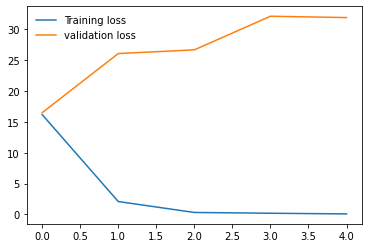

In [25]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [26]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [27]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [28]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       130
           1       0.98      0.99      0.99      1949

    accuracy                           0.97      2079
   macro avg       0.89      0.87      0.88      2079
weighted avg       0.97      0.97      0.97      2079



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।

In [29]:
 from sklearn import metrics

In [30]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)



In [31]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


In [32]:
import matplotlib.pyplot as plt



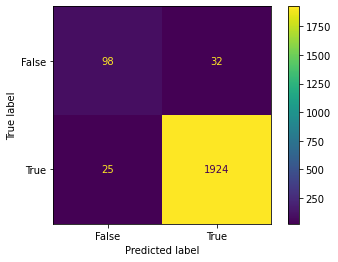

In [33]:
cm_display.plot()
plt.show()